## Code to Chapter 8 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1XrrSv4egSLojErCvicDTrwheaRHSSvEw?usp=sharing)

## Drug Molecule Generation with Conditional Variational Autoencoder (CVAE)

This notebook implements a Conditional Variational Autoencoder (CVAE) for generating drug molecules based on desired molecular properties. The model learns to generate molecules with specific characteristics like logP (lipophilicity), QED (drug-likeness), and SAS (synthetic accessibility score).

### Key Features:
- **Graph-based representation**: Uses molecular graphs instead of SMILES strings for better structural understanding
- **Conditional generation**: Generates molecules with desired properties
- **Relational Graph Convolution**: Custom layers for processing molecular graphs
- **Multiple loss functions**: Combines reconstruction, KL divergence, property prediction, and gradient penalty losses


## 1. Environment Setup and Dependencies

RDKit is an open source toolkit for cheminformatics and machine learning. This toolkit come in handy
if one is into drug discovery domain. In this example, RDKit is used to conveniently
and efficiently transform SMILES to molecule objects, and then from those obtain sets of atoms
and bonds.

We've already used SMILES in several chapters, starting Chapter 2. In case you are not familiar with the concept, below is a quick description.

Quoting from
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/)):

**"SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively human-readable.
Encoding molecules as a string both alleviates and facilitates database and/or web searching
of a given molecule. RDKit uses algorithms to accurately transform a given SMILES to
a molecule object, which can then be used to compute a great number of molecular properties/features."**

In [1]:
!pip install -q rdkit keras==2.15.0 tensorflow==2.15.0 tf-keras==2.15.0 #tensorstore==0.1.50

In [2]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

### Important Note on Installation
<font color='red'>If you encounter the error "numpy.dtype size changed, may indicate binary incompatibility",
restart the session and re-run all cells. This is a known compatibility issue between
different numpy versions and compiled extensions</font>

### What this does:
- **RDKit**: Open-source cheminformatics toolkit for molecular manipulation
- **TensorFlow/Keras**: Deep learning framework for building the CVAE
- **RDLogger.DisableLog**: Suppresses RDKit warning messages

## 2. Dataset Loading and Preprocessing

We use the [**ZINC – A Free Database of Commercially Available Compounds for
Virtual Screening**](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1360656/) dataset. The dataset comes with molecule
formula in SMILE representation along with their respective molecular properties such as
**logP** (water–octanal partition coefficient), **SAS** (synthetic
accessibility score) and **QED** (Qualitative Estimate of Drug-likeness).

In [3]:
# data from https://github.com/aspuru-guzik-group/selfies
csv_path = keras.utils.get_file(
    "/content/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("/content/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


### Dataset Information:
The **ZINC database** contains:
- **SMILES**: String representation of molecular structure
- **logP**: Lipophilicity (water-octanol partition coefficient) - affects drug absorption
- **qed**: Quantitative Estimate of Drug-likeness - overall drug potential
- **SAS**: Synthetic Accessibility Score - how easy to synthesize

In [4]:
smiles_set = set(df["smiles"].to_list())

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249455 entries, 0 to 249454
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   smiles  249455 non-null  object 
 1   logP    249455 non-null  float64
 2   qed     249455 non-null  float64
 3   SAS     249455 non-null  float64
dtypes: float64(3), object(1)
memory usage: 7.6+ MB


## 3. Hyperparameters and Configuration

In [6]:
# Molecular representation configuration
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)
print("Supported atoms:", SMILE_CHARSET)

# Bond type mappings - bidirectional for encoding/decoding
bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {
        0: Chem.BondType.SINGLE,
        1: Chem.BondType.DOUBLE,
        2: Chem.BondType.TRIPLE,
        3: Chem.BondType.AROMATIC,
    }
)

# Molecule size constraints based on SMILES length distribution
MIN_MOLSIZE = int(min(df["smiles"].str.len()) * 0.75)
MAX_MOLSIZE = int(max(df["smiles"].str.len()) * 1.5)
print(f"Molecule size range: {MIN_MOLSIZE} - {MAX_MOLSIZE}")

# Create atom-to-index mappings for neural network processing
SMILE_to_index = {c: i for i, c in enumerate(SMILE_CHARSET)}
index_to_SMILE = {i: c for i, c in enumerate(SMILE_CHARSET)}
atom_mapping = {**SMILE_to_index, **index_to_SMILE}

# Model hyperparameters
BATCH_SIZE = 25  # Training batch size
EPOCHS = 10  # Training epochs
VAE_LR = 5e-4  # Learning rate for VAE
NUM_ATOMS = 120  # Maximum atoms per molecule
ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types (11)
BOND_DIM = 4 + 1  # Bond types + non-bond indicator (5)
LATENT_DIM = 435  # Latent space dimensionality
k_tensor = 8_000  # Dataset size for Colab compatibility

print(f"Model dimensions - Atoms: {ATOM_DIM}, Bonds: {BOND_DIM}, Latent: {LATENT_DIM}")

Supported atoms: ['C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', 'P', 'Cl', 'Br']
Molecule size range: 6 - 163
Model dimensions - Atoms: 11, Bonds: 5, Latent: 435


### Why these parameters?
- **NUM_ATOMS=120**: Handles most drug-like molecules
- **LATENT_DIM=435**: Balances expressivity vs. computational cost
- **k_tensor=8000**: Reduced for Colab memory constraints

## 4. Molecular Graph Conversion Functions

### Why graph representation?
1. **Structural awareness**: Captures molecular topology better than sequences
2. **Permutation invariance**: Same molecule represented consistently
3. **Chemical validity**: Easier to enforce chemical rules

### 4.1 SMILES to Graph Conversion

In [7]:
def smiles_to_graph(smiles):
    """
    Convert a SMILES string to a molecular graph representation.

    Args:
        smiles (str): SMILES string representing the molecule.

    Returns:
        tuple: Adjacency tensor and feature tensor representing the molecule's graph.
    """
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensors
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), dtype="float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), dtype="float32")

    # Populate the tensors with atom and bond information
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Indicate "non-bond" in the last channel where no bond exists
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Indicate "non-atom" in the last column where no atom exists
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

### 4.2 Graph to Molecule Conversion

In [8]:
def graph_to_molecule(graph):
    """
    Convert a molecular graph representation back to a molecule object.

    Args:
        graph (tuple): A tuple containing adjacency and feature tensors.

    Returns:
        molecule (RWMol): An RDKit molecule object, or None if sanitization fails.
    """
    adjacency, features = graph

    # Create an editable molecule object
    molecule = Chem.RWMol()

    # Filter out "no atoms" and atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to the molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        molecule.AddAtom(atom)

    # Add bonds to the molecule
    bonds_ij, atoms_i, atoms_j = np.where(np.triu(adjacency) == 1)
    for bond_ij, atom_i, atom_j in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule to ensure chemical validity
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

## 5. Training Data Preparation

In [9]:
# Sampling and preparing the training dataset
train_df = df.sample(frac=0.75, random_state=42)  # Random state ensures reproducibility
train_df.reset_index(drop=True, inplace=True)

train_df = df.sample(frac=0.75, random_state=42)  # 75% for training
train_df.reset_index(drop=True, inplace=True)

# Initialize storage for graph representations and properties
adjacency_tensor, feature_tensor = [], []
logP_tensor, qed_tensor, condition_tensor = [], [], []

# Convert SMILES to graph representations
successful_conversions = 0
failed_conversions = 0

for idx in range(min(k_tensor, len(train_df))):
    try:
        smiles = train_df.loc[idx]["smiles"]
        logP = train_df.loc[idx]["logP"]
        qed = train_df.loc[idx]["qed"]
        SAS = train_df.loc[idx]["SAS"]

        # Convert to graph representation
        adjacency, features = smiles_to_graph(smiles)

        # Store graph and properties
        adjacency_tensor.append(adjacency)
        feature_tensor.append(features)
        logP_tensor.append(logP)
        qed_tensor.append(qed)
        condition_tensor.append([logP, qed, SAS])  # Conditioning vector

        successful_conversions += 1

    except Exception as e:
        failed_conversions += 1
        if failed_conversions < 10:  # Show first few errors
            print(f"Failed to process {smiles}: {e}")

# Convert lists to numpy arrays for use in neural networks
adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
logP_tensor = np.array(logP_tensor)
qed_tensor = np.array(qed_tensor)
condition_tensor = np.array(condition_tensor)

print(f"\nData preparation complete:")
print(f"- Successful conversions: {successful_conversions}")
print(f"- Failed conversions: {failed_conversions}")
print(f"- Final dataset shape: {adjacency_tensor.shape}")
print(f"- Property ranges:")
print(f"  logP: {logP_tensor.min():.2f} to {logP_tensor.max():.2f}")
print(f"  QED: {qed_tensor.min():.2f} to {qed_tensor.max():.2f}")


Data preparation complete:
- Successful conversions: 8000
- Failed conversions: 0
- Final dataset shape: (8000, 5, 120, 120)
- Property ranges:
  logP: -4.99 to 7.99
  QED: 0.16 to 0.95


## 6. Relational Graph Convolutional Layer

### Why Relational GCN?
- **Bond-type awareness**: Different weights for single, double, triple, aromatic bonds
- **Message passing**: Atoms share information through chemical bonds
- **Permutation invariance**: Same molecule gives same representation regardless of atom ordering


In [10]:
# Define a custom relational graph convolutional layer
class RelationalGraphConvLayer(layers.Layer):
    """
    Custom Relational Graph Convolutional Layer for molecular graphs.

    This layer implements message passing between atoms through different bond types.
    For each bond type, it aggregates information from connected atoms and applies
    a learnable transformation.

    The operation can be described as:
    H^(l+1) = σ(∑_r A_r * H^(l) * W_r)

    Where:
    - H^(l) is the feature matrix at layer l
    - A_r is the adjacency matrix for relation r (bond type)
    - W_r is the learnable weight matrix for relation r
    - σ is the activation function
    """

    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        # Initialize kernel weights
        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        # Initialize bias weights if use_bias is True
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs

        # Perform message passing by aggregating information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])

        # Apply linear transformation and add bias if applicable
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias

        # Reduce bond type dimension by summing over it
        x_reduced = tf.reduce_sum(x, axis=1)

        # Apply the activation function
        return self.activation(x_reduced)

## 7. Encoder and Decoder Architecture

### 7.1 Encoder (Recognition Network)

The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
These features are processed via a Graph Convolution layer, then are flattened and
processed by several Dense layers to derive `z_mean` and `log_var`, the
latent-space representation of the molecule.

**Graph Convolution layer**: The relational graph convolution layer implements
non-linearly transformed neighbourhood aggregations. We can define these layers as
follows:

`H_hat**(l+1) = σ(D_hat**(-1) * A_hat * H_hat**(l+1) * W**(l))`

Where `σ` denotes the non-linear transformation (commonly a ReLU activation), `A` the
adjacency tensor, `H_hat**(l)` the feature tensor at the `l-th` layer, `D_hat**(-1)` the
inverse diagonal degree tensor of `A_hat`, and `W_hat**(l)` the trainable weight tensor
at the `l-th` layer. Specifically, for each bond type (relation), the degree tensor
expresses, in the diagonal, the number of bonds attached to each atom.

Source:
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/))

In [11]:
def set_encoder(
    gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate
):
    """
    Build the encoder network that maps molecules to latent space.

    Architecture:
    1. Relational Graph Convolution layers - process molecular graphs
    2. Global Average Pooling - create fixed-size representation
    3. Dense layers - learn complex transformations
    4. Output layers - predict latent mean and variance

    Args:
        gconv_units (list): Units for each graph conv layer
        latent_dim (int): Latent space dimensionality
        adjacency_shape, feature_shape (tuple): Input tensor shapes
        dense_units (list): Units for dense layers
        dropout_rate (float): Regularization rate

    Returns:
        keras.Model: Encoder model
    """
    # Input layers for adjacency matrix and feature matrix
    adjacency = layers.Input(shape=adjacency_shape)
    features = layers.Input(shape=feature_shape)

    # Pass through relational graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Global average pooling to reduce the 2D graph representation to 1D
    x = layers.GlobalAveragePooling1D()(features_transformed)

    # Pass through dense layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Compute the mean and log variance for the latent space
    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)

    # Build the encoder model
    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")
    return encoder

### 7.2 Decoder (Generative Network)

The Decoder takes as input the latent-space representation and predicts
the graph adjacency matrix and feature matrix of the corresponding molecules.

In [12]:
def set_decoder(
    dense_units, dropout_rate, latent_dim, condition_dim, adjacency_shape, feature_shape
):
    """
    Build the decoder network that generates molecules from latent codes.

    Architecture:
    1. Concatenate latent vector with conditions (logP, QED, SAS)
    2. Dense layers - learn to map latent space to graph space
    3. Separate heads for adjacency and features
    4. Softmax normalization for valid probabilities

    Args:
        dense_units (list): Units for dense layers
        dropout_rate (float): Regularization rate
        latent_dim (int): Latent space dimensionality
        condition_dim (int): Number of conditioning properties
        adjacency_shape, feature_shape (tuple): Output tensor shapes

    Returns:
        keras.Model: Decoder model
    """
    # Input layer for the latent space vector
    latent_input = keras.Input(shape=(latent_dim,))
    condition_input = keras.Input(shape=(condition_dim,))

    # Concatenate latent vector with condition
    x = layers.Concatenate()([latent_input, condition_input])

    for units in dense_units:
        x = layers.Dense(units, activation="tanh")(x)  # relu
        x = layers.Dropout(dropout_rate)(x)

    # Generate the adjacency tensor
    x_adjacency = layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = layers.Reshape(adjacency_shape)(x_adjacency)

    # Symmetrize the adjacency tensor
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = layers.Softmax(axis=1)(x_adjacency)

    # Generate the feature tensor
    x_features = layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = layers.Reshape(feature_shape)(x_features)
    x_features = layers.Softmax(axis=2)(x_features)

    # Build the decoder model
    decoder = keras.Model(
        [latent_input, condition_input],
        outputs=[x_adjacency, x_features],
        name="decoder",
    )

    return decoder

## 8. Sampling Layer for Reparameterization Trick

### Why reparameterization?
- **Gradient flow**: Allows backpropagation through stochastic sampling
- **Stable training**: Reduces variance in gradient estimates
- **Mathematical elegance**: Separates deterministic and stochastic components

In [13]:
class Sampling(layers.Layer):
    """
    Custom sampling layer for the Variational Autoencoder (VAE).

    This layer implements the reparameterization trick, which allows
    for the backpropagation of gradients through a stochastic latent
    variable by introducing a random variable 'epsilon' with a known
    distribution (typically standard normal).
    """

    def call(self, inputs):
        """
        Perform the sampling operation.

        Args:
            inputs (list): A list containing the mean (z_mean) and log variance (z_log_var) of the latent space.

        Returns:
            Tensor: A sampled latent vector of the same shape as z_mean and z_log_var.
        """
        z_mean, z_log_var = inputs

        # Get batch size and dimensionality of latent space
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]

        # Sample epsilon from a standard normal distribution
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # Compute the sampled latent vector
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## 9. Complete CVAE Model

This model is trained to optimize four losses:

* Categorical crossentropy
* KL divergence loss
* Property prediction loss
* Graph loss (gradient penalty)

The categorical crossentropy loss function measures the model's
reconstruction accuracy. The Property prediction loss estimates the mean squared
error between predicted and actual properties after running the latent representation
through a property prediction model. The property
prediction of the model is optimized via binary crossentropy. The gradient
penalty is further guided by the model's property (QED) prediction.

A gradient penalty is an alternative soft constraint on the
1-Lipschitz continuity as an improvement upon the gradient clipping scheme from the
original neural network
("1-Lipschitz continuity" means that the norm of the gradient is at most 1 at every single
point of the function).
It adds a regularization term to the loss function.

In [14]:
class MoleculeGenerator(keras.Model):
    """
    Complete Conditional Variational Autoencoder for molecule generation.

    This model combines:
    1. Encoder: Maps molecules to latent space
    2. Decoder: Generates molecules from latent codes + conditions
    3. Property predictor: Predicts molecular properties from latent codes
    4. Multiple loss functions: Reconstruction, KL divergence, property prediction, gradient penalty
    """

    def __init__(self, encoder, decoder, min_len, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # Property prediction head
        self.property_prediction_layer = layers.Dense(
            1, activation="sigmoid", name="property_predictor"
        )

        # Molecule size constraints
        self.min_len = min_len
        self.max_len = max_len

        # Loss tracking
        self.train_loss_tracker = keras.metrics.Mean(name="train_loss")
        self.val_loss_tracker = keras.metrics.Mean(name="val_loss")

        # Individual loss component trackers
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.property_loss_tracker = keras.metrics.Mean(name="property_loss")
        self.gradient_penalty_tracker = keras.metrics.Mean(name="gradient_penalty")

    def train_step(self, data):
        """Custom training step with multiple loss components."""
        # Unpack data
        adjacency_tensor, feature_tensor, qed_tensor, condition_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        self.batch_size = tf.shape(qed_tensor)[0]

        # Forward pass with gradient tape
        with tf.GradientTape() as tape:
            # Get model outputs
            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = self(
                [graph_real[0], graph_real[1], condition_tensor], training=True
            )
            graph_generated = [gen_adjacency, gen_features]

            # Compute all loss components
            loss_components = self._compute_loss(
                z_log_var,
                z_mean,
                qed_tensor,
                qed_pred,
                graph_real,
                graph_generated,
                condition_tensor,
            )

            # Total loss is sum of all components
            total_loss = sum(loss_components)

        # Backpropagation
        gradients = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        # Update metrics
        self.train_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(loss_components[0])
        self.property_loss_tracker.update_state(loss_components[1])
        self.gradient_penalty_tracker.update_state(loss_components[2])
        self.recon_loss_tracker.update_state(loss_components[3] + loss_components[4])

        return {
            "loss": self.train_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "property_loss": self.property_loss_tracker.result(),
            "gradient_penalty": self.gradient_penalty_tracker.result(),
        }

    def _compute_loss(
        self,
        z_log_var,
        z_mean,
        qed_true,
        qed_pred,
        graph_real,
        graph_generated,
        condition_tensor,
    ):
        """
        Compute all loss components for training.

        Returns:
            list: [kl_loss, property_loss, gradient_penalty, adjacency_loss, features_loss]
        """
        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated

        # 1. Reconstruction losses (how well can we reconstruct the input?)
        adjacency_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(adjacency_real, adjacency_gen),
                axis=(1, 2),
            )
        )
        features_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(features_real, features_gen),
                axis=1,
            )
        )

        # 2. KL divergence loss (regularization term)
        # Encourages latent space to be close to standard normal distribution
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        # 3. Property prediction loss (can we predict properties from latent space?)
        # Fix: Squeeze qed_pred to match qed_true shape
        qed_pred_squeezed = tf.squeeze(qed_pred, axis=-1)
        property_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(qed_true, qed_pred_squeezed)
        )

        # 4. Gradient penalty for improved training stability
        gradient_penalty = self._gradient_penalty(
            graph_real, graph_generated, condition_tensor
        )

        return [kl_loss, property_loss, gradient_penalty, adjacency_loss, features_loss]

    def _gradient_penalty(self, graph_real, graph_generated, condition_tensor):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Interpolate between real and generated graphs
        alpha = tf.random.uniform([self.batch_size], 0.0, 1.0)
        adjacency_interp = self._interpolate(
            adjacency_real, adjacency_generated, alpha, dims=(1, 1, 1)
        )
        features_interp = self._interpolate(
            features_real, features_generated, alpha, dims=(1, 1)
        )

        # Compute gradients with respect to interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch([adjacency_interp, features_interp])
            _, _, logits, _, _ = self(
                [adjacency_interp, features_interp, condition_tensor], training=True
            )

        grads = tape.gradient(logits, [adjacency_interp, features_interp])

        # Calculate gradient penalties
        adjacency_penalty = (1.0 - tf.norm(grads[0], axis=1)) ** 2
        features_penalty = (1.0 - tf.norm(grads[1], axis=2)) ** 2

        return tf.reduce_mean(
            tf.reduce_mean(adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(features_penalty, axis=-1)
        )

    def _interpolate(self, real, generated, alpha, dims):
        alpha = tf.reshape(alpha, (self.batch_size, *dims))
        return (alpha * real) + ((1.0 - alpha) * generated)

    def inference(self, condition, batch_size=None):
        if not batch_size:
            batch_size = self.batch_size
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = self.decoder.predict(
            [z, condition]
        )

        # Convert to one-hot encoded adjacency matrix
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))

        # Convert to one-hot encoded feature matrix
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)

        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]

    def call(self, inputs):
        graph_input_1, graph_input_2, condition_input = inputs

        z_mean, z_log_var = self.encoder([graph_input_1, graph_input_2])
        z = Sampling()([z_mean, z_log_var])

        gen_adjacency, gen_features = self.decoder([z, condition_input])
        property_pred = self.property_prediction_layer(z_mean)

        return z_mean, z_log_var, property_pred, gen_adjacency, gen_features

## 10. Model Training

In [15]:
import tensorflow as tf

vae_optimizer = tf.keras.optimizers.Adam(learning_rate=VAE_LR)

# Define and build the encoder and decoder model
encoder = set_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512, 256, 128],
    dropout_rate=0.0,
)

decoder = set_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.25,
    condition_dim=condition_tensor.shape[1],
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

In [16]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 120, 120)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 120, 11)]            0         []                            
                                                                                                  
 relational_graph_conv_laye  (None, 120, 9)               495       ['input_1[0][0]',             
 r (RelationalGraphConvLaye                                          'input_2[0][0]']             
 r)                                                                                               
                                                                                            

In [17]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 435)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 438)                  0         ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 128)                  56192     ['concatenate[0][0]']   

In [18]:
# Compile the model with the specified optimizer
model = MoleculeGenerator(encoder, decoder, MIN_MOLSIZE, MAX_MOLSIZE)
model.compile(optimizer=vae_optimizer)

In [19]:
print(f"\nModel compiled successfully!")
print(
    f"Training data shape: Adjacency {adjacency_tensor.shape}, Features {feature_tensor.shape}"
)
print(f"Condition data shape: {condition_tensor.shape}")
print(f"Property data shape: {qed_tensor.shape}")


Model compiled successfully!
Training data shape: Adjacency (8000, 5, 120, 120), Features (8000, 120, 11)
Condition data shape: (8000, 3)
Property data shape: (8000,)


### Training Process

In [20]:
# Create callbacks for better training monitoring
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="loss", patience=5, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
]

# Train the model
history = model.fit(
    [adjacency_tensor, feature_tensor, qed_tensor, condition_tensor],
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
320/320 [==============================] - 262s 792ms/step - loss: 69076.0696 - kl_loss: 61.7032 - reconstruction_loss: 68942.9609 - property_loss: 0.5972 - gradient_penalty: 1.9876 - lr: 5.0000e-04
Epoch 2/10
320/320 [==============================] - 244s 762ms/step - loss: 69068.5769 - kl_loss: 13.9771 - reconstruction_loss: 69092.4141 - property_loss: 0.5859 - gradient_penalty: 1.9037 - lr: 5.0000e-04
Epoch 3/10
320/320 [==============================] - 241s 752ms/step - loss: 69231.1719 - kl_loss: 16.6042 - reconstruction_loss: 69254.6094 - property_loss: 0.6203 - gradient_penalty: 1.7349 - lr: 5.0000e-04
Epoch 4/10
320/320 [==============================] - ETA: 0s - loss: 69553.1040 - kl_loss: 290.7780 - reconstruction_loss: 69440.3906 - property_loss: 0.7032 - gradient_penalty: 1.9329
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
320/320 [==============================] - 249s 780ms/step - loss: 69553.6669 - kl_loss: 290.7780 - reconstr

In [21]:
history.history

{'loss': [69007.2734375,
  69108.921875,
  69273.578125,
  69733.8046875,
  69786.4453125,
  69722.828125],
 'kl_loss': [61.7032470703125,
  13.977139472961426,
  16.604246139526367,
  290.7779846191406,
  238.05300903320312,
  102.35453796386719],
 'reconstruction_loss': [68942.9609375,
  69092.4140625,
  69254.609375,
  69440.390625,
  69545.8828125,
  69617.90625],
 'property_loss': [0.5972099304199219,
  0.5858751535415649,
  0.6202635765075684,
  0.7031663656234741,
  0.5995856523513794,
  0.5960054397583008],
 'gradient_penalty': [1.9875894784927368,
  1.9037288427352905,
  1.7348527908325195,
  1.9328587055206299,
  1.9673538208007812,
  1.9813063144683838],
 'lr': [0.0005, 0.0005, 0.0005, 0.0005, 0.00025, 0.00025]}

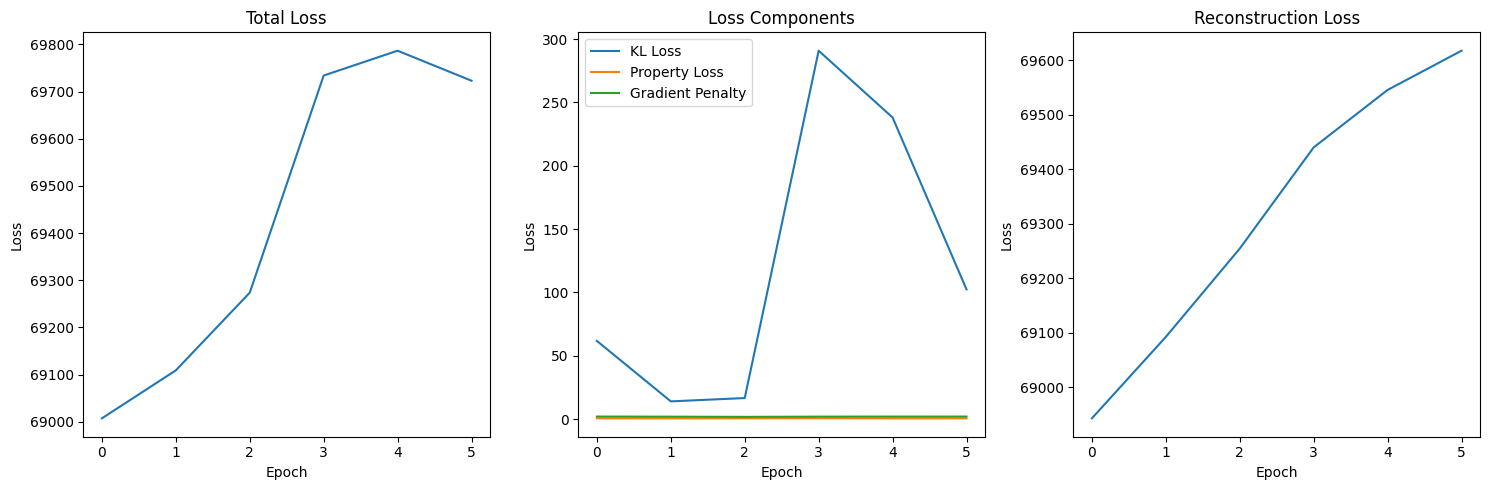

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history["loss"])
plt.title("Total Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.subplot(1, 3, 2)
plt.plot(history.history["kl_loss"], label="KL Loss")
plt.plot(history.history["property_loss"], label="Property Loss")
plt.plot(history.history["gradient_penalty"], label="Gradient Penalty")
plt.title("Loss Components")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history["reconstruction_loss"])
plt.title("Reconstruction Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()

In [23]:
import gc

gc.collect()
print("Memory cleanup completed.")

Memory cleanup completed.


## 11. Molecule Generation and Analysis

### 11.1 Utility Functions

We use our model to generate new valid molecules from different points of the latent space.

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw


def rwmol_to_smiles(rwmol):
    """Convert RDKit RWMol object to SMILES string."""
    if rwmol is None:
        return None
    try:
        mol = rwmol.GetMol()
        smiles = Chem.MolToSmiles(mol)
        return smiles if smiles else None
    except:
        return None


def calculate_molecular_properties(mol):
    """Calculate basic molecular properties."""
    if mol is None:
        return None

    try:
        from rdkit.Chem import Descriptors, QED

        return {
            "molecular_weight": Descriptors.MolWt(mol),
            "logp": Descriptors.MolLogP(mol),
            "qed": QED.qed(mol),
            "num_atoms": mol.GetNumAtoms(),
            "num_bonds": mol.GetNumBonds(),
        }
    except:
        return None


def analyze_generation_results(molecules, conditions, title="Generated Molecules"):
    """Analyze and display generation results."""
    print(f"\n{'='*20} {title} {'='*20}")

    # Filter valid molecules
    valid_mols = [mol for mol in molecules if mol is not None]
    validity_rate = len(valid_mols) / len(molecules) * 100

    print(f"Validity rate: {validity_rate:.1f}% ({len(valid_mols)}/{len(molecules)})")

    if len(valid_mols) == 0:
        print("No valid molecules generated!")
        return [], {}

    # Get unique molecules
    unique_smiles = set()
    unique_mols = []
    mol_counts = {}

    for mol in valid_mols:
        smiles = rwmol_to_smiles(mol)
        if smiles and smiles not in unique_smiles:
            unique_smiles.add(smiles)
            unique_mols.append(mol)
            mol_counts[smiles] = 1
        elif smiles:
            mol_counts[smiles] += 1

    uniqueness_rate = len(unique_mols) / len(valid_mols) * 100
    print(
        f"Uniqueness rate: {uniqueness_rate:.1f}% ({len(unique_mols)}/{len(valid_mols)})"
    )

    # Calculate property statistics
    if len(unique_mols) > 0:
        properties = [calculate_molecular_properties(mol) for mol in unique_mols]
        properties = [p for p in properties if p is not None]

        if properties:
            prop_stats = {
                "molecular_weight": [p["molecular_weight"] for p in properties],
                "logp": [p["logp"] for p in properties],
                "qed": [p["qed"] for p in properties],
                "num_atoms": [p["num_atoms"] for p in properties],
            }

            print(f"\nProperty Statistics (n={len(properties)}):")
            for prop_name, values in prop_stats.items():
                mean_val = np.mean(values)
                std_val = np.std(values)
                print(f"  {prop_name}: {mean_val:.2f} ± {std_val:.2f}")

    return unique_mols, mol_counts

### 11.2 Generate Molecules with Low logP

In [25]:
batch_size = 1_000
q_head, q_tail = 0.1, 0.9

In [26]:
df.iloc[:, 1:].quantile(q_head), df.iloc[:, 1:].quantile(q_tail)

(logP    0.546640
 qed     0.522484
 SAS     2.121359
 Name: 0.1, dtype: float64,
 logP    4.177000
 qed     0.881494
 SAS     4.239843
 Name: 0.9, dtype: float64)

In [27]:
import gc

gc.collect()

0

### 11.3 Generate Molecules with High logP

Targeted conditions for high logP molecules:
logP: 4.18
QED range: 0.62 - 0.85
SAS range: 2.32 - 3.75

Generating 1000 molecules...
32/32 [==============================] - 3s 83ms/step

==================== High logP Molecules ====================
Validity rate: 75.4% (754/1000)
Uniqueness rate: 2.3% (17/754)

Property Statistics (n=17):
  molecular_weight: 54.23 ± 9.00
  logp: 0.11 ± 0.74
  qed: 0.36 ± 0.05
  num_atoms: 3.00 ± 0.00

Displaying first 17 unique molecules:


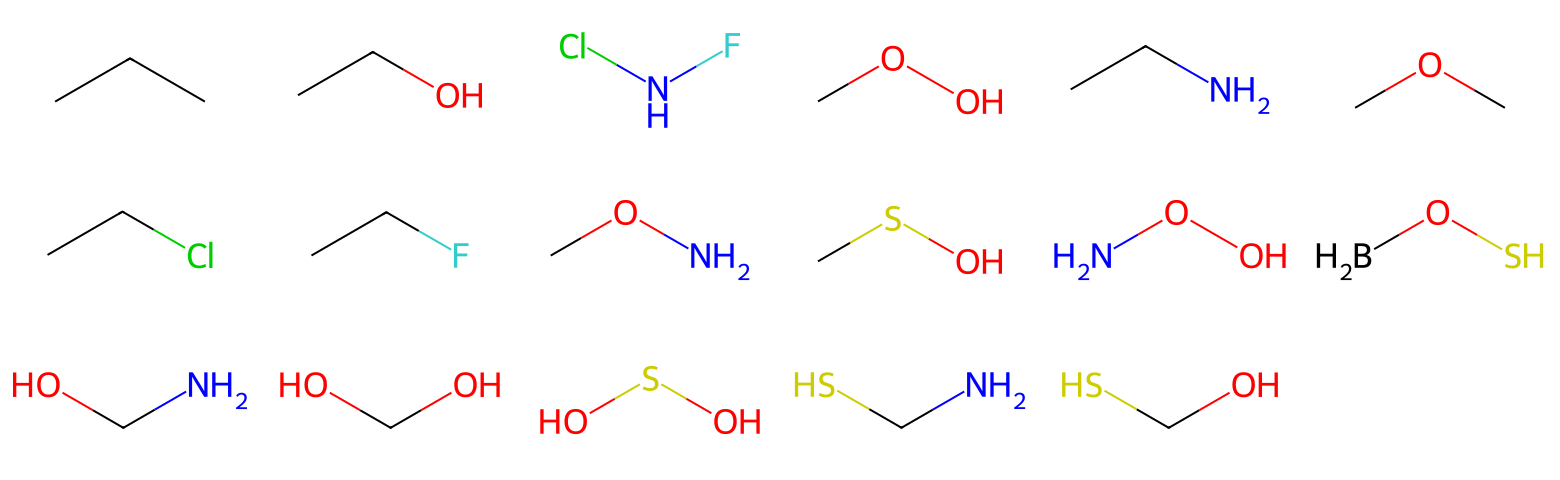


Most frequently generated molecules:
  CCC (generated 710 times)
  CCO (generated 12 times)
  COC (generated 9 times)
  COO (generated 4 times)
  CCN (generated 4 times)


In [28]:
# Create conditions for high logP molecules
desired_conditions = np.array(
    [df.iloc[:, 1:].quantile(x) for x in [0.2, 0.4, 0.6, 0.8]]
)
desired_conditions[:, 0] = df.iloc[:, 1].quantile(q_tail)  # Set high logP

print(f"Targeted conditions for high logP molecules:")
print(f"logP: {desired_conditions[0, 0]:.2f}")
print(
    f"QED range: {desired_conditions[:, 1].min():.2f} - {desired_conditions[:, 1].max():.2f}"
)
print(
    f"SAS range: {desired_conditions[:, 2].min():.2f} - {desired_conditions[:, 2].max():.2f}"
)

# Repeat conditions for batch generation
desired_conditions = np.repeat(desired_conditions, repeats=batch_size // 4, axis=0)

# Generate molecules
print(f"\nGenerating {batch_size} molecules...")
molecules_high_logp = model.inference(desired_conditions, batch_size=batch_size)

# Analyze results
unique_mols_high_logp, mol_counts_high_logp = analyze_generation_results(
    molecules_high_logp, desired_conditions, "High logP Molecules"
)

# Visualize unique molecules
if len(unique_mols_high_logp) > 0:
    display_count = min(30, len(unique_mols_high_logp))
    print(f"\nDisplaying first {display_count} unique molecules:")

    img = Draw.MolsToGridImage(
        unique_mols_high_logp[:display_count], molsPerRow=6, subImgSize=(260, 160)
    )
    display(img)

    # Show most frequently generated molecules
    frequent_mols = sorted(
        mol_counts_high_logp.items(), key=lambda x: x[1], reverse=True
    )[:5]
    print(f"\nMost frequently generated molecules:")
    for smiles, count in frequent_mols:
        print(f"  {smiles} (generated {count} times)")

### 11.4 Generate Molecules with Low logP

Targeted conditions for high logP molecules:
logP: 0.55
QED range: 0.62 - 0.85
SAS range: 2.32 - 3.75

Generating 1000 molecules...
32/32 [==============================] - 4s 123ms/step

==================== Low logP Molecules ====================
Validity rate: 68.5% (685/1000)
Uniqueness rate: 2.9% (20/685)

Property Statistics (n=20):
  molecular_weight: 56.06 ± 18.95
  logp: 0.18 ± 0.71
  qed: 0.36 ± 0.05
  num_atoms: 3.05 ± 0.74

Displaying first 20 unique molecules:


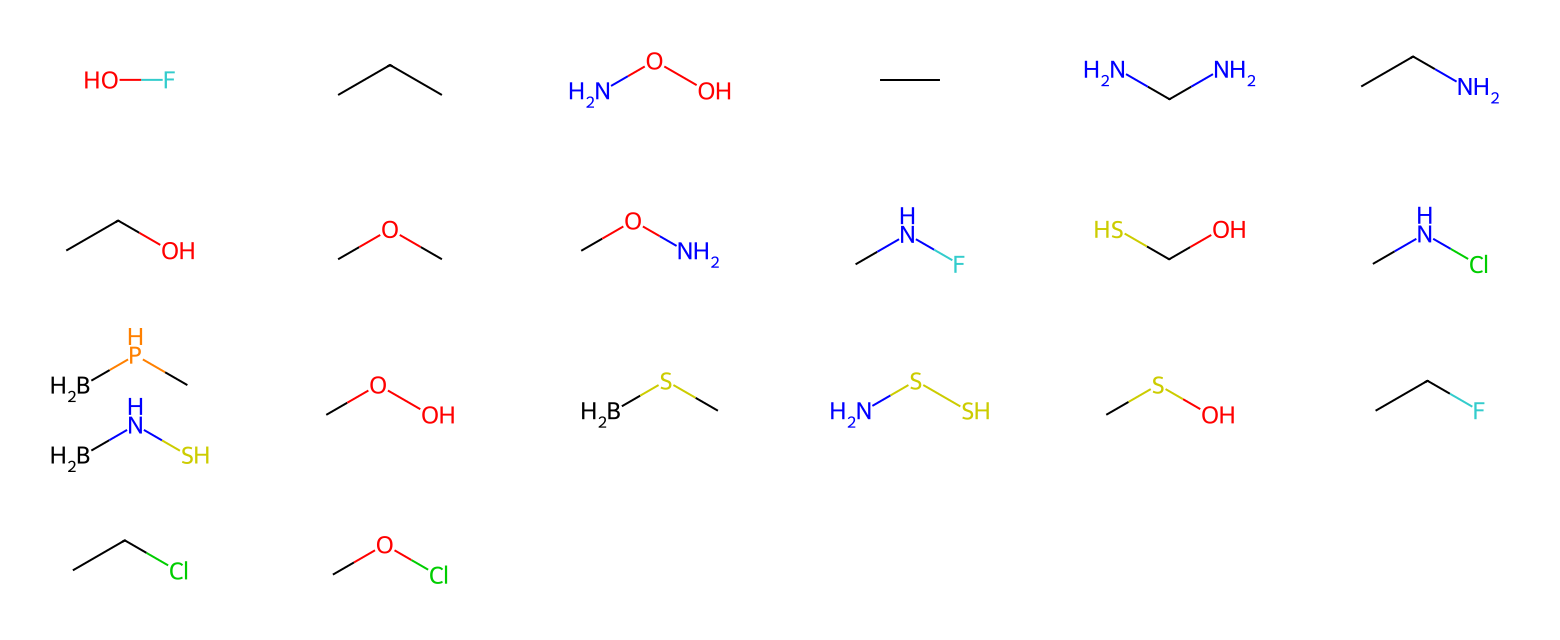


Most frequently generated molecules:
  CCC (generated 642 times)
  CCO (generated 13 times)
  CCN (generated 5 times)
  COO (generated 4 times)
  COC (generated 3 times)


In [31]:
# Create conditions for high logP molecules
desired_conditions = np.array(
    [df.iloc[:, 1:].quantile(x) for x in [0.2, 0.4, 0.6, 0.8]]
)
desired_conditions[:, 0] = df.iloc[:, 1].quantile(q_head)  # Set low logP

print(f"Targeted conditions for high logP molecules:")
print(f"logP: {desired_conditions[0, 0]:.2f}")
print(
    f"QED range: {desired_conditions[:, 1].min():.2f} - {desired_conditions[:, 1].max():.2f}"
)
print(
    f"SAS range: {desired_conditions[:, 2].min():.2f} - {desired_conditions[:, 2].max():.2f}"
)

# Repeat conditions for batch generation
desired_conditions = np.repeat(desired_conditions, repeats=batch_size // 4, axis=0)

# Generate molecules
print(f"\nGenerating {batch_size} molecules...")
molecules_low_logp = model.inference(desired_conditions, batch_size=batch_size)

# Analyze results
unique_mols_low_logp, mol_counts_low_logp = analyze_generation_results(
    molecules_low_logp, desired_conditions, "Low logP Molecules"
)

# Visualize unique molecules
if len(unique_mols_low_logp) > 0:
    display_count = min(30, len(unique_mols_low_logp))
    print(f"\nDisplaying first {display_count} unique molecules:")

    img = Draw.MolsToGridImage(
        unique_mols_low_logp[:display_count], molsPerRow=6, subImgSize=(260, 160)
    )
    display(img)

    # Show most frequently generated molecules
    frequent_mols = sorted(
        mol_counts_low_logp.items(), key=lambda x: x[1], reverse=True
    )[:5]
    print(f"\nMost frequently generated molecules:")
    for smiles, count in frequent_mols:
        print(f"  {smiles} (generated {count} times)")

## 12. Latent Space Analysis and Visualization

In [32]:
class LatentSpaceAnalyzer:
    """Utility class for analyzing and visualizing the learned latent space."""

    def __init__(self, model, adjacency_data, feature_data, property_data):
        self.model = model
        self.adjacency_data = adjacency_data
        self.feature_data = feature_data
        self.property_data = property_data

        # Encode training data to latent space
        print("Encoding training data to latent space...")
        self.z_mean, self.z_log_var = model.encoder.predict(
            [adjacency_data, feature_data]
        )
        print(f"Latent representations shape: {self.z_mean.shape}")

    def plot_property_distribution(self, property_values, property_name, bins=50):
        """Plot distribution of molecular properties."""
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.hist(property_values, bins=bins, alpha=0.7, edgecolor="black")
        plt.xlabel(property_name)
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {property_name}")

        plt.subplot(1, 2, 2)
        plt.boxplot(property_values)
        plt.ylabel(property_name)
        plt.title(f"{property_name} Box Plot")

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"{property_name} Statistics:")
        print(f"  Mean: {np.mean(property_values):.3f}")
        print(f"  Std:  {np.std(property_values):.3f}")
        print(f"  Min:  {np.min(property_values):.3f}")
        print(f"  Max:  {np.max(property_values):.3f}")

    def plot_latent_space_2d(
        self, property_values, property_name, alpha=0.5, figsize=(12, 10)
    ):
        """
        Visualize 2D projection of latent space colored by molecular properties.

        This helps understand how the model organizes molecules with different
        properties in the latent space.
        """
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            self.z_mean[:, 0],
            self.z_mean[:, 1],
            c=property_values,
            cmap="plasma",
            alpha=alpha,
            s=10,
        )
        plt.colorbar(scatter, label=property_name)
        plt.xlabel("Latent Dimension 0")
        plt.ylabel("Latent Dimension 1")
        plt.title(f"Latent Space Colored by {property_name}")

        # Add property value ranges to the plot
        vmin, vmax = np.min(property_values), np.max(property_values)
        plt.figtext(
            0.02, 0.02, f"{property_name} range: [{vmin:.2f}, {vmax:.2f}]", fontsize=10
        )

        plt.show()

    def plot_multiple_properties(self, properties_dict, figsize=(15, 10)):
        """Plot latent space for multiple properties in subplots."""
        n_properties = len(properties_dict)
        cols = min(3, n_properties)
        rows = (n_properties + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=figsize)

        # Fix: Handle different subplot configurations properly
        if n_properties == 1:
            axes = [axes]
        elif rows == 1 and cols > 1:
            axes = list(axes)
        elif rows > 1 and cols == 1:
            axes = list(axes)
        elif rows > 1 and cols > 1:
            axes = axes.flatten()

        for i, (prop_name, prop_values) in enumerate(properties_dict.items()):
            ax = axes[i]
            scatter = ax.scatter(
                self.z_mean[:, 0],
                self.z_mean[:, 1],
                c=prop_values,
                cmap="plasma",
                alpha=0.6,
                s=8,
            )
            ax.set_xlabel("Latent Dimension 0")
            ax.set_ylabel("Latent Dimension 1")
            ax.set_title(f"Latent Space - {prop_name}")
            plt.colorbar(scatter, ax=ax)

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    def analyze_latent_clusters(self, n_clusters=5):
        """Perform clustering analysis on the latent space."""
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score

        print(f"Performing K-means clustering with {n_clusters} clusters...")

        # Fit K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(self.z_mean)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(self.z_mean, cluster_labels)
        print(f"Average silhouette score: {silhouette_avg:.3f}")

        # Plot clusters
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        scatter = plt.scatter(
            self.z_mean[:, 0],
            self.z_mean[:, 1],
            c=cluster_labels,
            cmap="tab10",
            alpha=0.7,
            s=10,
        )
        plt.xlabel("Latent Dimension 0")
        plt.ylabel("Latent Dimension 1")
        plt.title("Latent Space Clusters")
        plt.colorbar(scatter)

        # Plot cluster centers
        centers = kmeans.cluster_centers_
        plt.scatter(
            centers[:, 0], centers[:, 1], c="red", marker="x", s=100, linewidth=3
        )

        plt.subplot(1, 2, 2)
        cluster_counts = np.bincount(cluster_labels)
        plt.bar(range(n_clusters), cluster_counts)
        plt.xlabel("Cluster ID")
        plt.ylabel("Number of Molecules")
        plt.title("Molecules per Cluster")

        plt.tight_layout()
        plt.show()

        return cluster_labels, kmeans


# Create analyzer instance
analyzer = LatentSpaceAnalyzer(
    model,
    adjacency_tensor[:k_tensor],
    feature_tensor[:k_tensor],
    condition_tensor[:k_tensor],
)

Encoding training data to latent space...
250/250 [==============================] - 3s 11ms/step
Latent representations shape: (8000, 435)


#### Property distribution

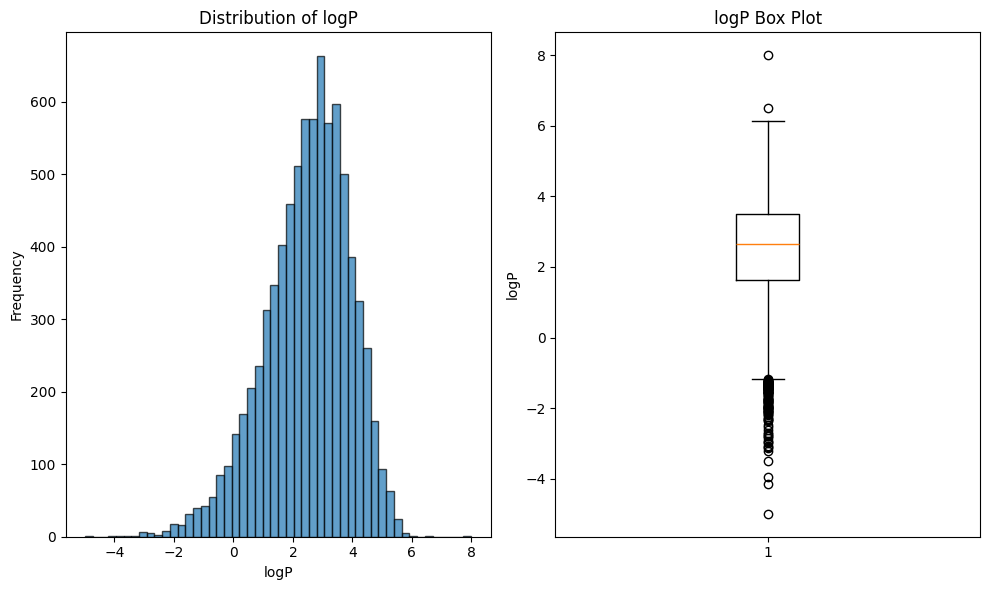

logP Statistics:
  Mean: 2.487
  Std:  1.427
  Min:  -4.993
  Max:  7.994


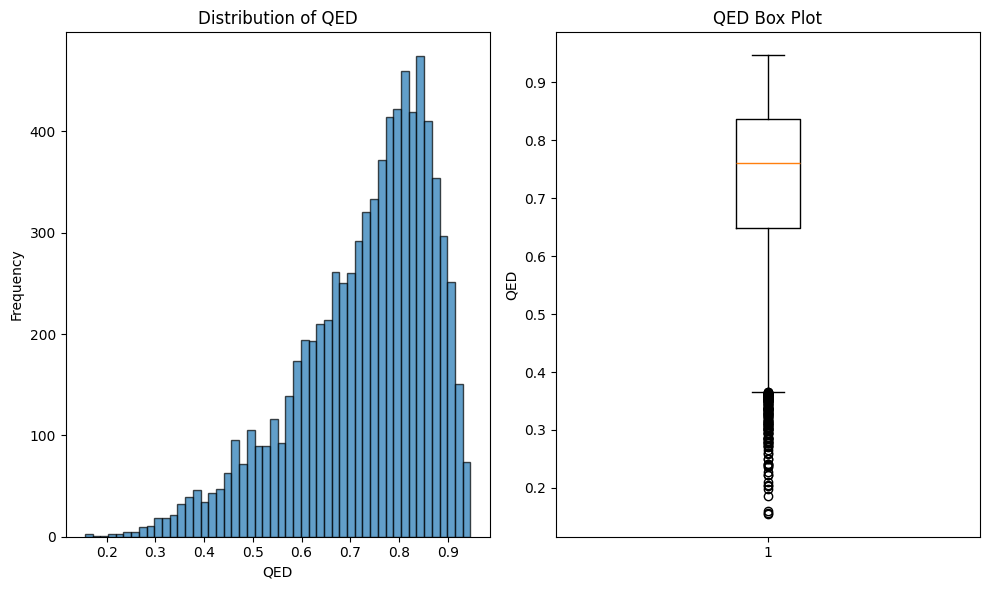

QED Statistics:
  Mean: 0.729
  Std:  0.139
  Min:  0.155
  Max:  0.947


In [33]:
# logP analysis
analyzer.plot_property_distribution(logP_tensor[:k_tensor], "logP")

# QED analysis
analyzer.plot_property_distribution(qed_tensor[:k_tensor], "QED")

#### Latent space visualization

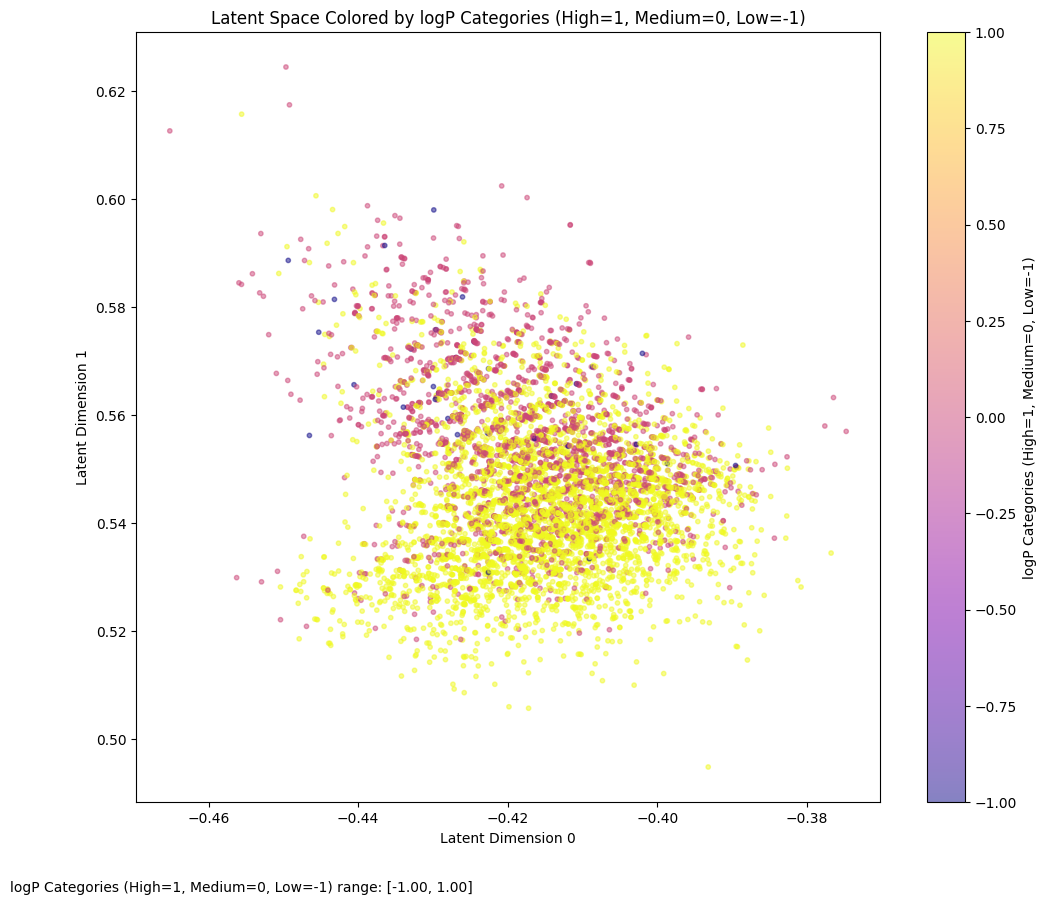

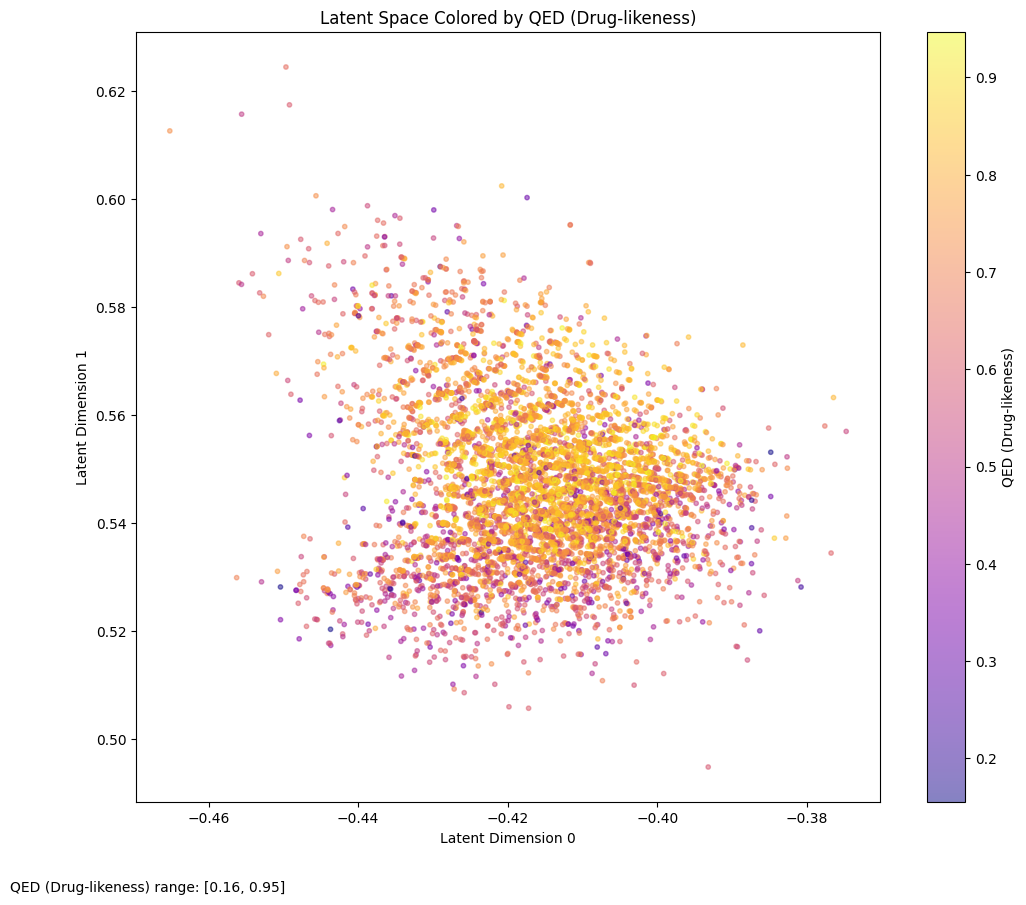

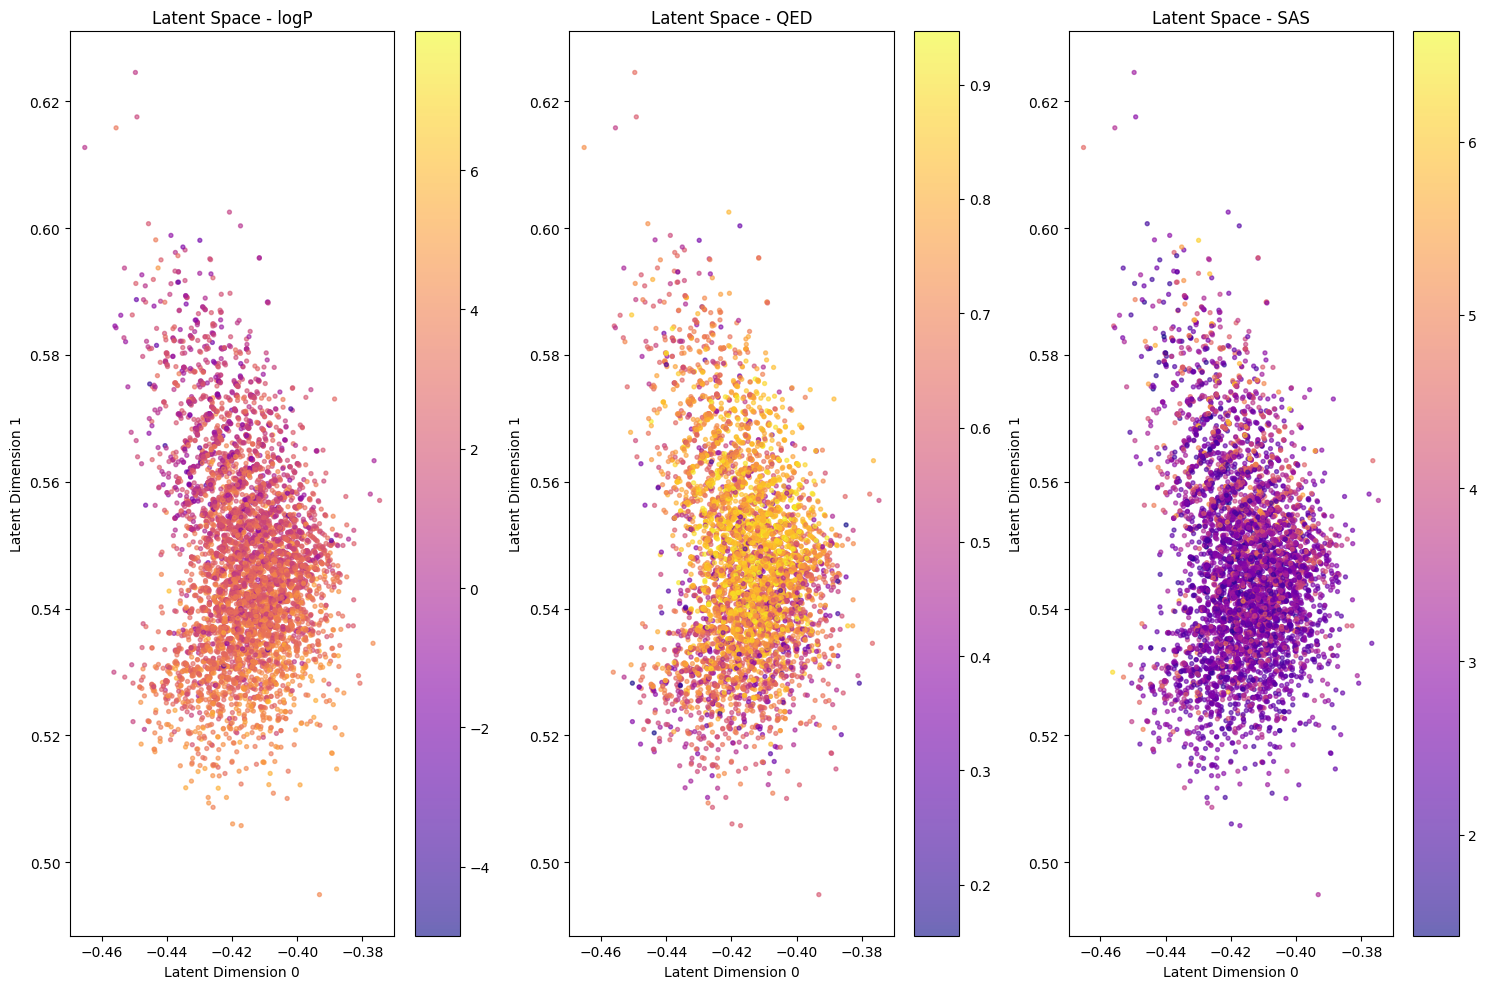

In [34]:
# Create categorical logP for better visualization
format_logP = np.where(
    logP_tensor[:k_tensor] >= 2, 1, np.where(logP_tensor[:k_tensor] <= -2, -1, 0)
)

# Plot latent spaces
analyzer.plot_latent_space_2d(format_logP, "logP Categories (High=1, Medium=0, Low=-1)")
analyzer.plot_latent_space_2d(qed_tensor[:k_tensor], "QED (Drug-likeness)")

# Plot multiple properties together
properties_dict = {
    "logP": logP_tensor[:k_tensor],
    "QED": qed_tensor[:k_tensor],
    "SAS": condition_tensor[:k_tensor, 2],
}
analyzer.plot_multiple_properties(properties_dict)

#### Cluster analysis

Performing K-means clustering with 6 clusters...
Average silhouette score: 0.223


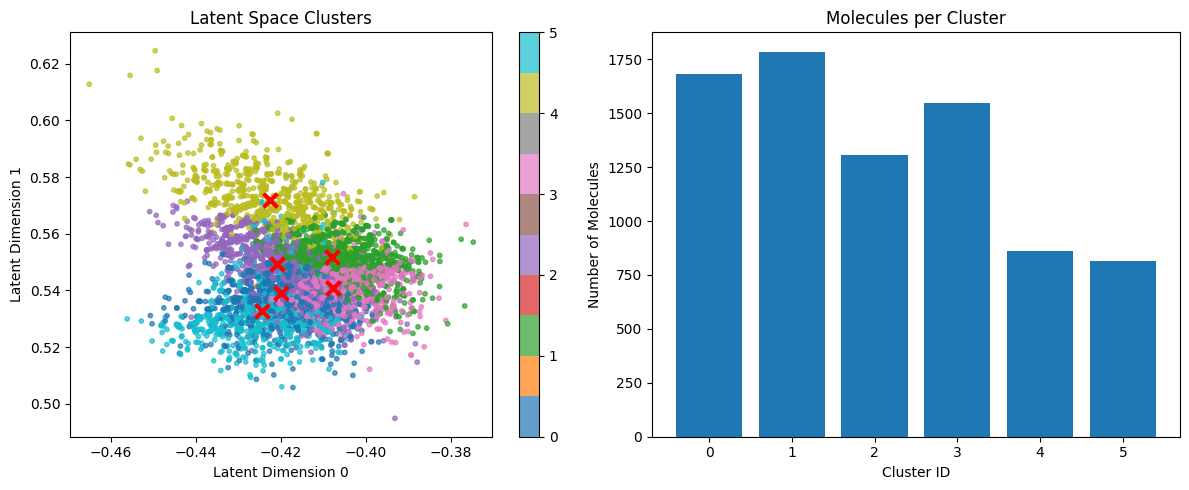


Cluster Property Analysis:
Cluster 0: logP=2.80, QED=0.75, SAS=2.81
Cluster 1: logP=2.27, QED=0.78, SAS=3.24
Cluster 2: logP=2.04, QED=0.76, SAS=2.94
Cluster 3: logP=2.82, QED=0.70, SAS=3.02
Cluster 4: logP=1.43, QED=0.73, SAS=3.32
Cluster 5: logP=3.52, QED=0.57, SAS=2.95


In [35]:
cluster_labels, kmeans = analyzer.analyze_latent_clusters(n_clusters=6)

# Analyze cluster properties
print("\nCluster Property Analysis:")
for i in range(6):
    cluster_mask = cluster_labels == i
    if np.sum(cluster_mask) > 0:
        cluster_logp = np.mean(logP_tensor[:k_tensor][cluster_mask])
        cluster_qed = np.mean(qed_tensor[:k_tensor][cluster_mask])
        cluster_sas = np.mean(condition_tensor[:k_tensor, 2][cluster_mask])
        print(
            f"Cluster {i}: logP={cluster_logp:.2f}, QED={cluster_qed:.2f}, SAS={cluster_sas:.2f}"
        )

In [39]:
import pickle
import os
import json

save_dir = "./model/"

# Save the complete model
print("Saving complete model...")
# model.save(os.path.join(save_dir, "molecule_vae_complete.h5"))

# Save encoder and decoder separately (more flexible for inference)
print("Saving encoder and decoder separately...")
encoder.save(os.path.join(save_dir, "encoder.h5"))
decoder.save(os.path.join(save_dir, "decoder.h5"))

# Save model weights only (smaller file size)
print("Saving model weights...")
model.save_weights(os.path.join(save_dir, "model_weights.h5"))

# Save training history
print("Saving training history...")
with open(os.path.join(save_dir, "training_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

# Also save as JSON for easy reading
with open(os.path.join(save_dir, "training_history.json"), "w") as f:
    # Convert numpy arrays to lists for JSON serialization
    history_json = {}
    for key, values in history.history.items():
        history_json[key] = [float(v) for v in values]
    json.dump(history_json, f, indent=2)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving complete model...
Saving encoder and decoder separately...
Saving model weights...
Saving training history...


In [40]:
!zip -r /content/latent_model.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/training_history.pkl (deflated 37%)
  adding: content/models/model_weights.h5 (deflated 18%)
  adding: content/models/training_history.json (deflated 58%)
  adding: content/models/encoder.h5 (deflated 11%)
  adding: content/models/decoder.h5 (deflated 19%)


In [41]:
from google.colab import files

files.download("/content/latent_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Possible code improvements:

1. DATA LOADING AND PREPROCESSING:
   - Use tf.data.Dataset for efficient data pipeline
   - Implement data caching and prefetching
   - Add data augmentation for better generalization

2. MEMORY OPTIMIZATION:
   - Use mixed precision training (tf.keras.mixed_precision)
   - Implement gradient checkpointing for large models
   - Add memory cleanup between training batches

3. MODEL ARCHITECTURE:
   - Use separable convolutions in GCN layers
   - Add residual connections for deeper networks
   - Implement attention mechanisms for better molecular understanding

4. TRAINING IMPROVEMENTS:
   - Add learning rate scheduling
   - Implement curriculum learning (start with simple molecules)
   - Add validation set for better monitoring

5. GENERATION QUALITY:
   - Implement beam search for molecule generation
   - Add molecular validity constraints during generation
   - Use reinforcement learning for property optimization